## Modelling and Simulation

This page is based on a Jupyter notebook, which is accessible through the repository. 

Additionally, it was exported to python source code, which can equally be downloaded and run.

It is recommended to use a virtual environment and the associated requirements file.

Running the jupyter/python simulation file, two graphic windows open (case they do not pop up pls check in the PC task bar and make them visible): on the left hand side, an interactive animation (with possibility to apply a perturbation torque, and to reset to initial conditions), and on the right hand side, the time series of control variables - they are updated on a click.

### Parameters
- Wheel parameters
- DC  Motor parameters
- Pendulum parameters
- Sensor parameters
- Controller parameters
- System parameters
- Simulation configuration

In [1]:
import numpy as np
import math

# Parameters
# to-do: if not self-explaining, add info how to calculate or measure

g = 9.81  # Gravitational acceleration (m*s^2)

# Wheel parameters
wheelradius = 0.3  # Radius of Reaction wheel (m)
wheelheight = 0.01  # height of Reaction wheel (m)
wheelrho=1250 # mass density of 100% infill PLA — as used in 3D printing — is typically 1.25 g/cm³ 
#m2 = 0.1  # Mass of Wheel (kg)
m2 = 3.14*wheelradius**2*wheelheight*wheelrho  # Mass of Wheel (kg)
#I2 = 0.0027  # Inertia moment of Wheel (Kg*m^2)
I2 = 0.5*m2*wheelradius**2  # Inertia moment of Wheel (Kg*m^2)

# DC  Motor parameters
#would be nice to have combinations for motor1, motor2, and motor3
motormass=0.1 #kg, ad hoc estimate
m2 = m2+motormass  # updated
I2 = 0.5*m2*wheelradius**2  # Inertia moment of Wheel (Kg*m^2)
#max voltages
#max rpm
ke = 3.69e-2  # Electrical constant of DC Motor (Vs/rad)
Ng = 0.83  # Transmission ratio of DC Motor
kt = ke * Ng  # Mechanical constant of DC Motor (Nm/A)
R = 2.85  # Resistor of DC Motor (Ohm)
L = 3.73e-4  # Inductance of DC Motor (Henry)
J = 0.0027  # Inertia Motor (Kgm^2)
B = 3.85e-3  # Damping of DC Motor (Nn/v)
#time constants
tau_el=L/R  #electrical constant (order 0.1 ms)
tau_mech=J/B  #mechanical constant (order 100 ms)
# Motor Limit
MotorLimit = True # Set to False if you don't serious about hardware Limitation
# internal encoder ?
# gear properties ?
# gear ratio
# driver properties ? PWM vs DAC ?
# power supply ? 

# Pendulum parameters
L1 = 0.5  # Length of Pendulum (from pivot to center of mass) (m)
#L2 = 0.18  # Length of Pendulum (m)
L2 = L1  # Length of Pendulum (m)
#m1 = 0.1  # Mass of Pendulum (kg)
m1 = m2  # Mass of Pendulum (kg)
#I1 = 0.0212  # Inertia moment of Pendulum (Kg*m^2)
I1 = m2*L1**2  # Inertia moment of Pendulum (Kg*m^2)
dp = 0.01  # Pendulum damping constant (unit ? how to calculate, how to measure)

# Sensor parameters


#Controller parameters
Stabilize_Controller = "LQR" # Select stabilize mode: "LQR" or "PID"
StabilizeBound = 25  # Angle at which switch from Bang-bang swing up to PID/LQR starts to stabilize (degree)
# criteria for break mode ?

# Manual controller parameters?
# some manual control wheel with some handle or so ?
# some kinda gaming wheel as user interface ? with some haptic/manual feedback ?

# Controller parameters for Bang-bang?
# Margin ?

# Controller parameters for PID
Kp = 2143 #PID gain others ? how to calculate 

# Controller parameters for LQR
Q_LQR = np.array([[342, 0, 0, 0],  # Weight for qp
                  [0, 541, 0, 0],  # Weight for qp_d
                  [0, 0, 1, 0],  # Weight for qr
                  [0, 0, 0, 1]])  # Weight for qr_d    
R_LQR = 100  # Weight for the control input

N_LQR = np.array([[0],  # No cross-coupling terms for LQR
                  [0],
                  [0],
                  [0]])

#System parameters ?
# Arduino ? Delay? Digitation? Memory? Speed?

# Simulation configuration
#time
# Sound 
Sound = False # Flag to enable/disable sound
plot_rootlocus = False # Flag to enable/disable Plot root locus


In [2]:
def resetInitialState():
    global init_qp,init_qp_d ,init_qr,init_qr_d,init_Tm,init_Tp
    
    # Initial state

    init_qp = 180.0  # Initial pendulum angle (degree)
    init_qp_d = 0.0  # Initial pendulum speed

    init_qr = 0.0  # Initial reaction wheel angle
    init_qr_d = 0.0  # Initial reaction wheel speed

    init_Tm = 0.0  # Initial reaction wheel torque
    init_Tp = 0.0  # Initial disturbance torque

resetInitialState()


### Wheel simulation


### DC motor simulation

Model

![DC motor diagrams](../img/dcmotor.png)

Parameter

- `va` - Applied Voltage
- `R` - Resistance
- `L` - Inductance
- `i` - Current
- `b` - Damping coefficient
- `J` - Rotor Inertia
- `ke` - Back EMF constant
- `kt` - Torque constant
- `θ` - Rotor shaft angle

**Dynamical model**

Electrical part

&emsp; $va = R i + L \frac{di}{dt} + k_e \frac{dθ}{dt}$

Electromechanical Conversion

&emsp; $T_{m} = k_t i$

Mechanical Part

&emsp; $T_{m} = b \frac{dθ}{dt} + J\frac{d^2θ}{dt^2}$

If required, mechanical part can also include static or aerodynamic friction


In [3]:
def MotorDynamics(va, dt):
    '''
    updates dc motor torque based on input voltage and time step 
    '''
    #global qr_d, qr, curr_prev, curr_d, curr
    curr = (va - qr_d * ke - L * curr_d) / R
    curr_d = (curr - curr_prev)/dt
    Tm = curr * kt
    qr_dd = (Tm - B * qr_d) / J
    qr_d = qr_d + qr_dd * dt
    qr = qr + qr_d * dt
    curr_prev = curr
    return Tm


**Steady state model**

zeroing time variations (dynamic derivatives):

&emsp; $ L \frac{di}{dt}=0$

&emsp; $J\frac{dω}{dt}=0$

Electrical part

&emsp; $va = R i + k_e ω $

Mechanical Part

&emsp; $T_{m} = k_t i = b ω$

In [4]:
def MotorSteadyState(va, dt):
    '''
    updates dc motor torque based on input voltage and time step 
    '''
    #global qr_d, qr, curr_prev, curr_d, curr
    curr = (va - qr_d * ke) / R
    curr_d = (curr - curr_prev)/dt
    Tm = curr * kt
    qr_dd = (Tm - B * qr_d) / J
    qr_d = qr_d + qr_dd * dt
    qr = qr + qr_d * dt
    curr_prev = curr
    return Tm


**Speed-Torque Curve**

&emsp; $T_{m} =  \frac{k_t}{R} (va-k_e ω)$ 

&emsp; $\Leftrightarrow$ $ω = \frac{va}{k_e}-\frac{R}{k_e k_t}T_m$

This linear inverse correlation is called the **load line**.

**Reference points**

&emsp; $ω(T_m=0) = \frac{va}{k_e} = ω_{max} $  (zero load, maximum speed)

&emsp; $T_m(ω=0) = \frac{k_t}{R} va = k_t I_{stall}= Tm_{max}$ (full load, maximum torque, zero speed)

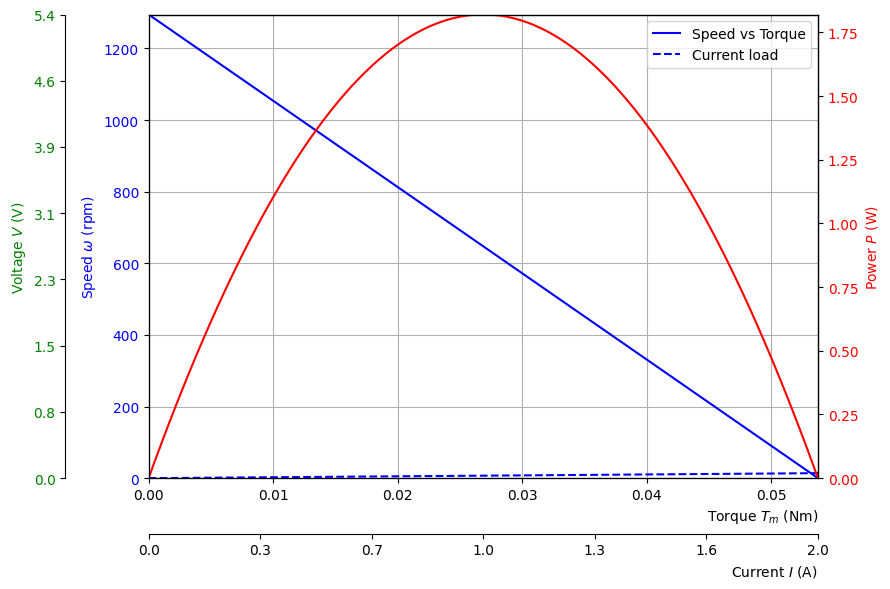

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
va = 5            #applied voltage

# Torque range
Tm = np.linspace(0,kt*va/R , 100)

# Speed-torque curve
omega = va/ke - R / (ke * kt) * Tm

# Power curve
P = omega * Tm

# Set axis limits
x_min, x_max = Tm.min(), Tm.max()
y_min, y_max = omega.min()*60/6.28, omega.max()*60/6.28
p_min, p_max = P.min(), P.max()

fig, ax1 = plt.subplots(figsize=(9, 6))

# Main plot: Torque vs Speed
ax1.plot(Tm, omega*60/6.28, label='Speed vs Torque', color='b')
ax1.plot(Tm, Tm/B, label='Current load', color='b', linestyle='--')
ax1.set_ylabel('Speed $\\omega$ (rpm)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('Torque $T_m$ (Nm)', loc='right')
ax1.xaxis.set_label_position('bottom')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('outward', 0))
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Additional x-axis for Current (aligned with Tm, sharing origin)
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
tm_ticks = ax1.get_xticks()
ax2.set_xticks(tm_ticks)
ax2.set_xticklabels([f"{(tick/kt):.1f}" for tick in tm_ticks])
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))
ax2.set_xlabel('Current $I$ (A)', loc='right')

# Additional y-axis for Voltage (aligned with omega, sharing origin, on left)
ax3 = ax1.twinx()
ax3.spines['left'].set_position(('outward', 60))
ax3.yaxis.set_label_position('left')
ax3.yaxis.set_ticks_position('left')
ax3.set_ylim(ax1.get_ylim())
omega_ticks = ax1.get_yticks()
ax3.set_yticks(omega_ticks)
ax3.set_yticklabels([f"{(ke*tick/(60/6.28) ):.1f}" for tick in omega_ticks])
ax3.set_ylabel('Voltage $V$ (V)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Additional y-axis for Power
ax4 = ax1.twinx()
ax4.plot(Tm, P, label='Power', color='r')
ax4.set_ylabel('Power $P$ (W)', color='r')
ax4.tick_params(axis='y', labelcolor='r')
ax4.set_ylim(p_min, p_max)  # restrict power axis to min/max

# Grid on both x and y axes
ax1.grid(True, which='both', axis='both')
ax1.legend()
#ax4.legend()
plt.tight_layout()
plt.show()


### Static transfer curve - voltage vs speed

Electrical part

&emsp; $va = R i + k_e ω$

Mechanical Part

&emsp; $T_{m} = k_t i = b ω$

Transfer curve

&emsp; $va = R \frac{b ω}{k_t} + k_e ω = (1+\frac{Rb}{k_e k_t}) k_e ω $

&emsp; $ω = \frac{va}{(1+\frac{Rb}{k_e k_t}) k_e} $


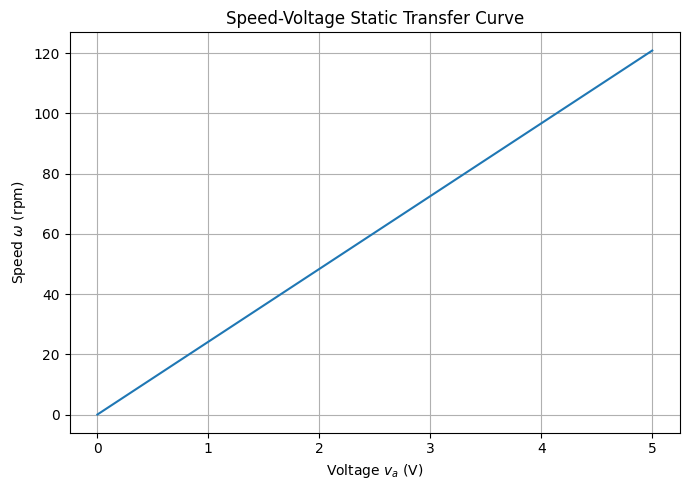

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Voltage range
va = np.linspace(0, 5, 100)

# Speed-voltage static transfer curve
omega =  va / ((1 + (R * B) / (ke * kt)) * ke)

plt.figure(figsize=(7, 5))
plt.plot(va, omega*60/6.28)
plt.xlabel('Voltage $v_a$ (V)')
plt.ylabel('Speed $\\omega$ (rpm)')
plt.title('Speed-Voltage Static Transfer Curve')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Time series Test function for DC motor simulator 
import numpy as np
import math
import matplotlib.pyplot as plt

def simulationTest_motordc_timeSeries(dt, t_end,T,TH,tag,mode):
    # initialize start values
    qr = 0.0
    qr_d = 0.0
    curr = 0.0
    curr_prev = 0.0
    curr_d = 0.0
    #initialize output
    Tmm = []
    Imm = []
    wmm = []
    Vmm = []

    t = np.arange(0, t_end + dt, dt)

    for tx in t:
        #value = MotorDynamics(vx, dt)
        if(mode=='ramp'):
            vx=5*tx/t_end
        elif (mode=='step'):
            vx=5
        elif (mode=='pwm'):
            vx = np.where((tx % T) < TH, 5, 0)  #pwm
        elif (mode=='onoff'):
            vx = np.where(tx < t_end/2, 5, 0)  #pwm
        #curr = (vx - qr_d * ke - L * curr_d) / R
        #curr_d = (curr - curr_prev)/dt
        curr_d = (vx - qr_d * ke - R * curr) / L
        curr = curr + curr_d * dt
        value = curr * kt
        qr_dd = (value - B * qr_d) / J
        qr_d = qr_d + qr_dd * dt
        qr = qr + qr_d * dt
        curr_prev = curr
        Tmm.append(value)
        wmm.append(qr_d)
        Imm.append(curr)
        Vmm.append(vx)

    Tmm = np.array(Tmm)
    wmm = np.array(wmm)
    Imm = np.array(Imm)
    Vmm = np.array(Vmm)

    # Top-left: Time series input (voltage)
    axs[0, 0].plot(t, Vmm,label=f'{tag}')
    axs[0, 0].set_title('Applied (PWM)')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('Voltage (V)')
    axs[0, 0].grid(True)

    # Bottom-left: Time series output1 (angular velocity)
    axs[1, 0].plot(t, wmm, label=f'{tag}')
    axs[1, 0].set_title('Output: Angular Velocity')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Angular Velocity (rad/s)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Top-right: Time series output2 (motor torque)
    axs[0, 1].plot(t, Tmm, label=f'{tag}')
    axs[0, 1].set_title('Output:Torque')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Motor Torque (Nm)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Bottom-right: Time series output3 (current)
    axs[1, 1].plot(t, Imm, label=f'{tag}')
    axs[1, 1].set_title('Output: Current')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('Current (A)')
    axs[1, 1].legend()
    axs[1, 1].grid(True)


### Simulation - time series - voltage step function - short time scale (ms)
- Time vector: step 0.1 ms, end time 3 ms
- Applied voltage: 
  - step function from 0 to 5V 
- Results: 
  - Current and Torque follow the applied signal, with a lag due to the motors electrical time constant $t_{el}=\frac{J}{B} \approx 0.1 ms$
  - The amplitude of current and torque are determined by resistance and conversion coefficient
  - The angular velocity increases linearly over time, as expected for integration on this short time scale.
  - While the curves were calculated numerically, the result matches the well known analytical function for RL circuit. 

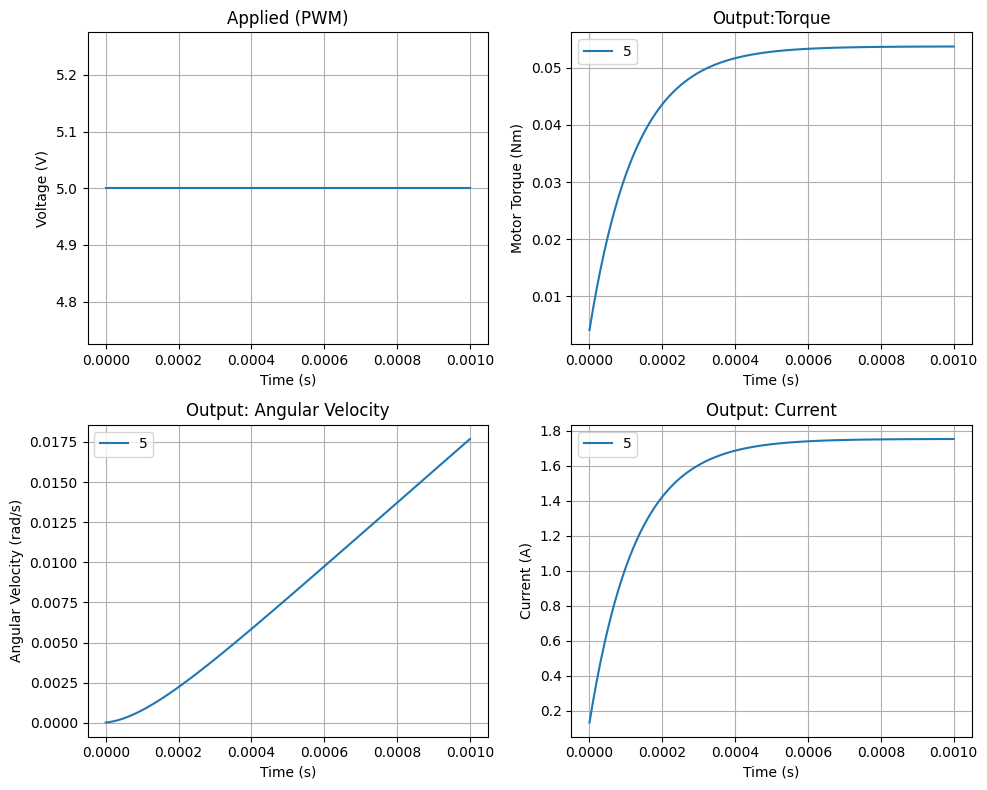

In [8]:
T=1e-3
TH=T*np.array([0.25, 0.5, 0.75])
dt = 0.01e-3
t_end = 1e-3  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
simulationTest_motordc_timeSeries(dt, t_end,T,T,5,'step')
plt.tight_layout()
plt.legend()
plt.show()


### Simulation - time series - voltage step function - long time scale (seconds)
- Time vector: step 0.1 ms, end time 3 s
- Applied voltage: 
  - step function from 0 to 5V 
- Results: 
  - Current and Torque follow the applied signals step function, with negligible delay on this time scale
  - The amplitude of current and torque are determined by resistance and conversion coefficient
  - The angular velocity increases linearly and then reaches its terminal value. 
  - Current and torque decrease near to terminal velocity. 
  - The motors mechanical time constant $t_{mech}=\frac{J}{B}$ governs the time time scale towards reaching final value.
  - At low load (low rotational inertia) the mechanical time constant is of order ~0.1 s.
  - When additional load attached, the rotational inertia increases, and so does the time constant. 

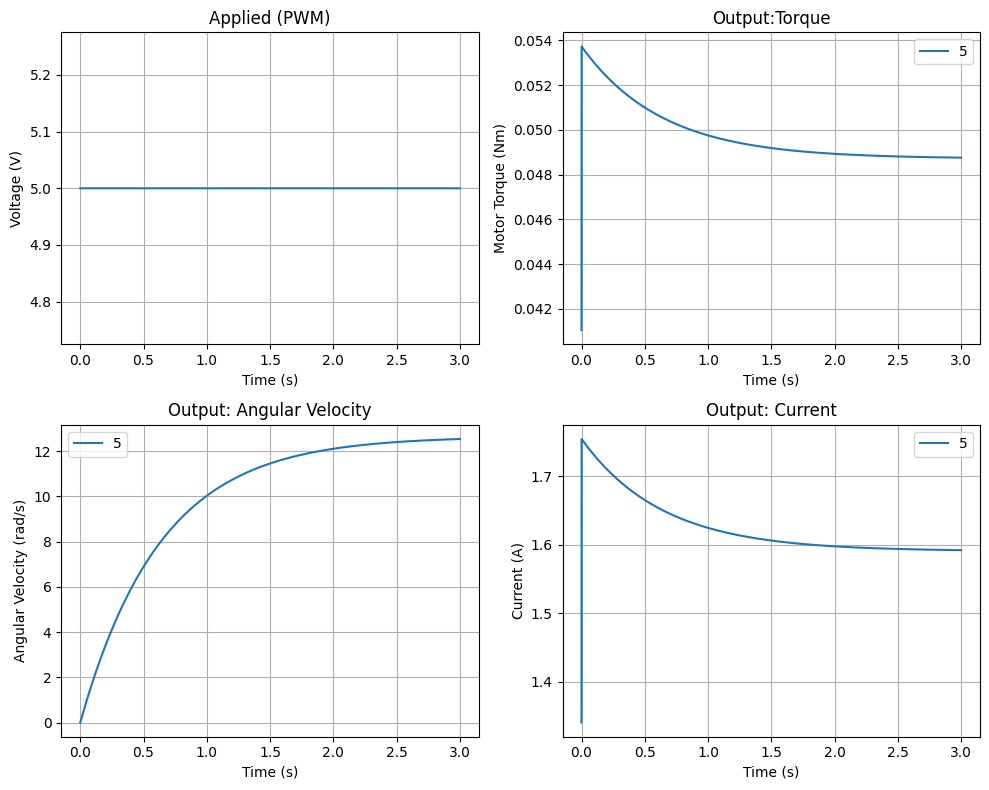

In [9]:
T=1e-3
dt = 0.1e-3
t_end = 3000e-3  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
simulationTest_motordc_timeSeries(dt, t_end,T,T,5,'step')
plt.tight_layout()
plt.legend()
plt.show()


### Simulation - time series - voltage On/Off - long time scale (seconds)
- Time vector: step 0.1 ms, end time 5 s
- Applied voltage: 
  - 5 V first half, then 0V 
- Results: 
  - Current and Torque follow the Voltage, but with transient overshoots
  - When switching from On to Off, current and torque show a negative transient
  - The significant negative current peak can be a problem for DC power supply
  - To protect power supplies, it is best practice to connect a diode or a capacitor in parallel to the DC motor

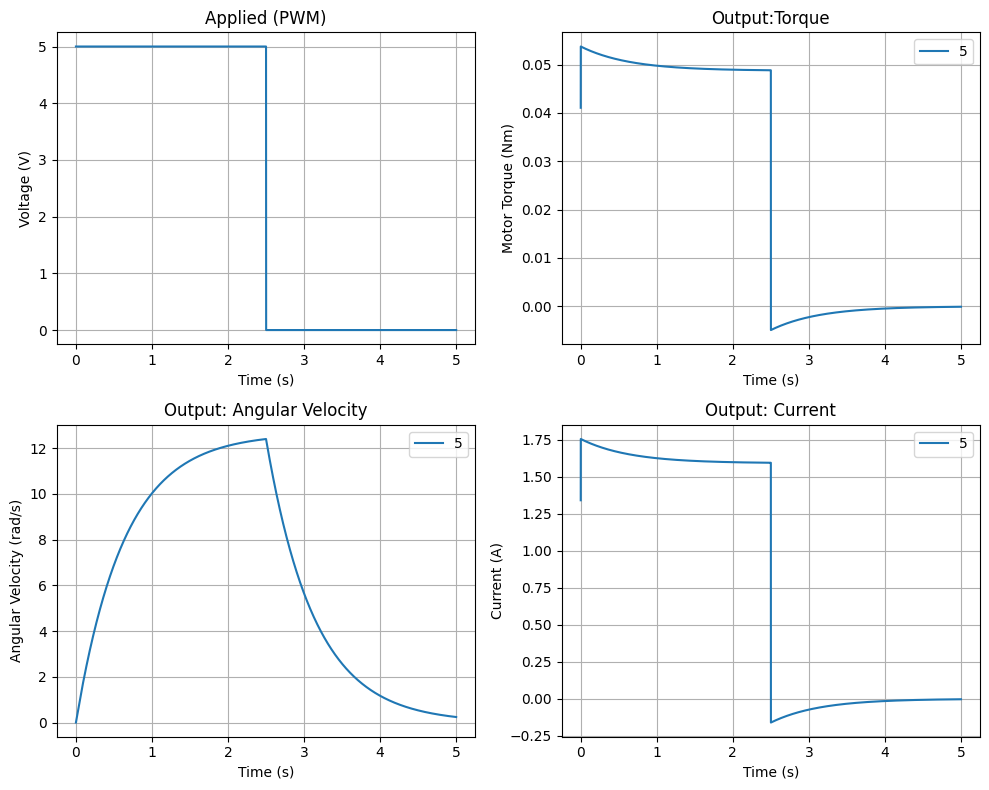

In [10]:
T=1e-3
dt = 0.1e-3
t_end = 5000e-3  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
simulationTest_motordc_timeSeries(dt, t_end,T,T,5,'onoff')
plt.tight_layout()
plt.legend()
plt.show()


### Simulation - time series - voltage ramp
- Time vector: step 0.1 ms, end time 1 s
- Applied voltage: 
  - Linear Voltage ramp from 0-5V
- Results: 
  - Current and Torque follow the applied signal
  - The angular velocity increases quadratically (integrative effect)
  - Using smooth transition with linear voltage ramps is always a good strategy.

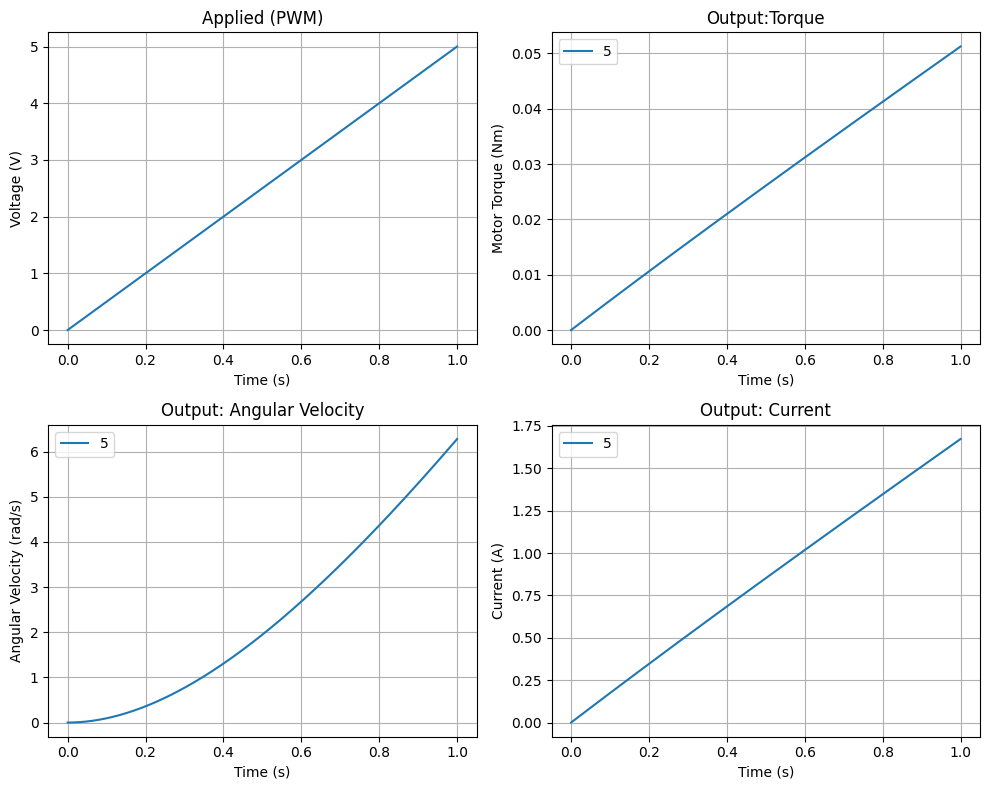

In [11]:
T=1e-3
TH=T*np.array([0.25, 0.5, 0.75])
dt = 0.1e-3
t_end = 1000e-3  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
simulationTest_motordc_timeSeries(dt, t_end,T,T,5,'ramp')
plt.tight_layout()
plt.legend()
plt.show()


### Simulation  - time series - PWM - short time scale (milliseconds)
- Time vector: step 0.1 ms, end time 10 ms
- Applied voltage: 
  - 0-5 V TTL PWM
  - PWM frqeuency f = 490 Hz or 980 Hz (typical values for Arduino PWM)
  - Duty cycle as parameter: 25%, 50%, 75%
- Results: 
  - Current and Torque follow the applied signal, with a lag due to the motors electrical time constant $\t_{el}=\frac{J}{B} \approx 0.1 ms
  - The amplitude of current and torque are determined by resistance and conversion coefficient
  - The response can be classified comparing the time constants: 
    - for the pwm signal, we have period $T=1/f_{pwm}$, high time $T_H=duty \cdot T$ , and low time $T_L=(1-duty) \cdot T$ 
    - for the motor, we have the motors electrical time constant $t_{el}=\frac{J}{B} \approx 0.1 ms$
  - The motors mechanical time constant $t_{mech}=\frac{J}{B} \approx 100 ms$ is not relevant on this time scale
  - The angular velocity increases linearly over time, as expected for integration on this short time scale.
  - It shows a ripple when pwm time constants are near to motor time constant.

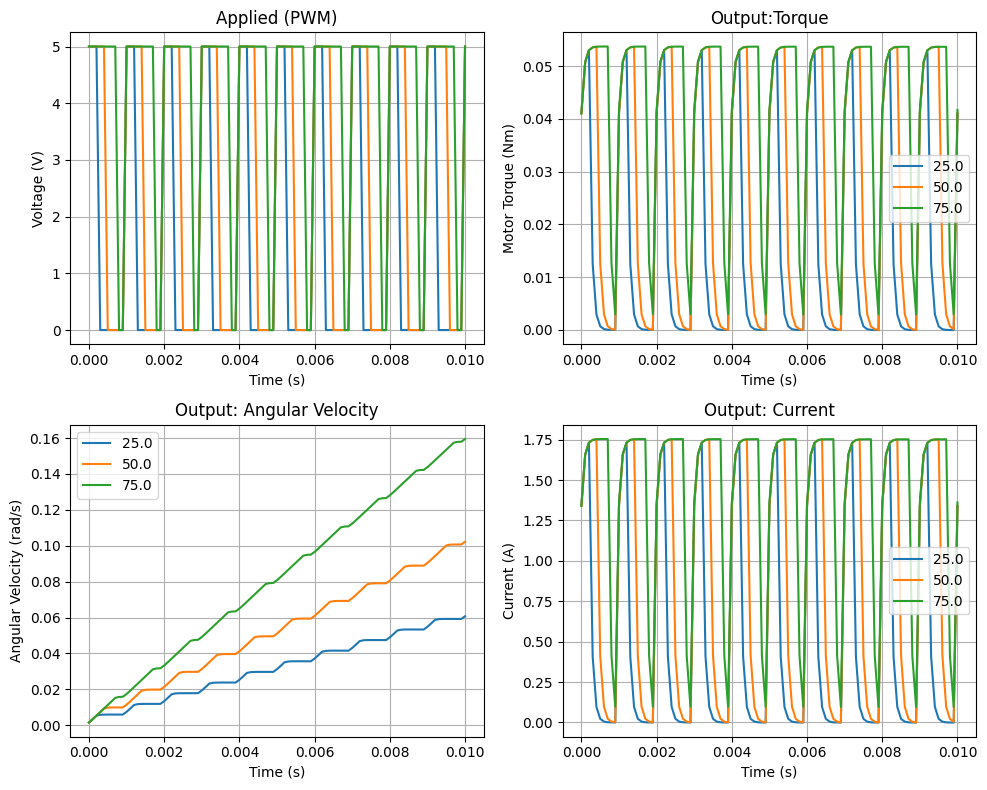

In [12]:
T=1e-3
TH=T*np.array([0.25, 0.5, 0.75])
dt = 0.1e-3
t_end = 10e-3  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for THH in TH:
    simulationTest_motordc_timeSeries(dt, t_end,T,THH,100*THH/T,'pwm')
plt.tight_layout()
plt.legend()
plt.show()


### Simulation  - time series -  PWM - long time scale (seconds)
- Time vector: step 0.1 ms, end time 3 seconds
- Applied voltage: 
  - 0-5 V TTL PWM
  - PWM frqeuency f = 980 Hz 
  - Duty cycle as parameter: 25%, 50%, 75%
- Results: 
  - The angular velocity increases linearly and then reaches its terminal value. 
  - Both the rate of increase and the terminal values scale with the PWMs duty cycle. 
  - The motors mechanical time constant $t_{mech}=\frac{J}{B}$ governs the time time scale towards reaching final value.
  - At low load (low rotational inertia) the mechanical time constant is of order ~0.1 s.
  - When additional load attached, the rotational inertia increases, and so does the time constant. 
  - Also the damping coefficient may vary, for example at very fast rotation (damping inverse to friction).
  - Current and Torque envelope shows slight variation over time.
  - While the amplitude is constant, a slight negative offset is noted at terminal velocity.

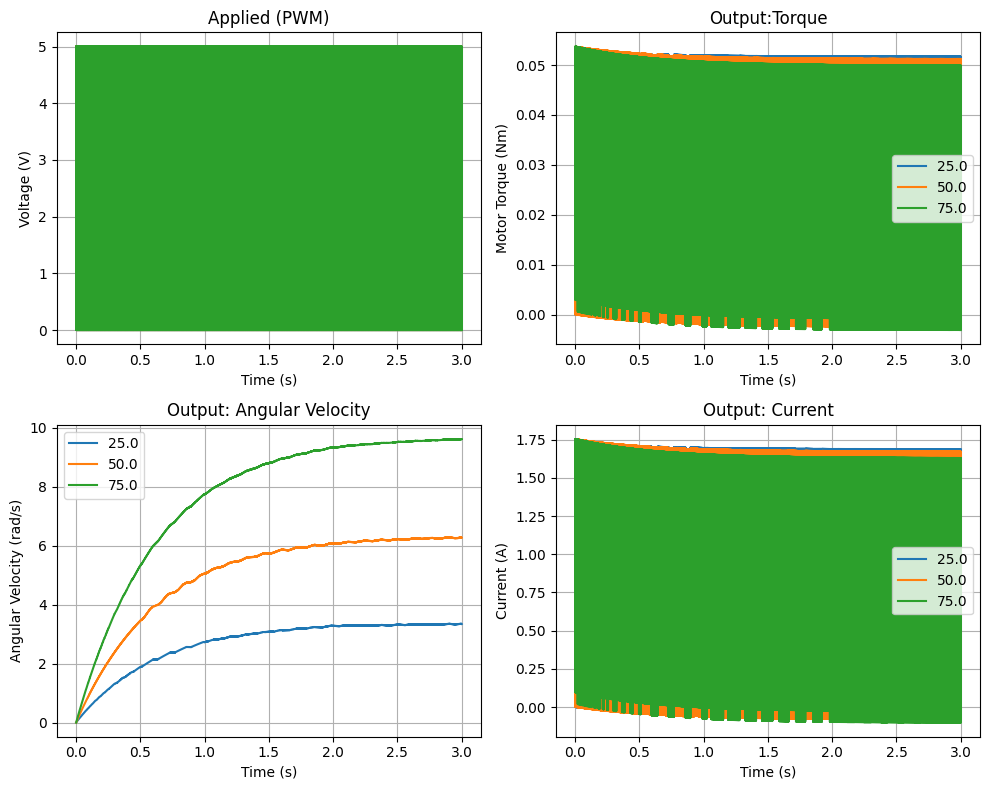

In [13]:
T=1e-3
TH=T*np.array([0.25, 0.5, 0.75])
dt = 0.1e-3
t_end = 3000e-3  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for THH in TH:
    simulationTest_motordc_timeSeries(dt, t_end,T,THH,100*THH/T,'pwm')
plt.tight_layout()
plt.legend()
plt.show()


### Simulation  - time series - PWM - tstep influence
- Time vector: 
  - end time 3 seconds
  - step varies: 0.02 ms, 0.1 ms, 0.2 ms
- Applied voltage: 
  - 0-5 V TTL PWM
  - PWM frqeuency f = 980 Hz 
  - Duty cycle: 10%
- Results: 
  - The resulting angular velocity is consistent as long as the numerical time step is well below the time cosntants of applied pwm voltage signal and the dystem (motor).
  - As a rule of thumb, a factor of 10 should be respected. 
  - To simulate the full dynamic range of PWM, very small time steps are required. 
  - Example: Arduino PWM 'analogWrite()' with 8bit resolution would need $dt= 1 ms / 2560 \approx 400 ns$. 
  - Also the amplitude of Current and Torque become unreliable when step inadequately chosen. 
  - The pwm time constant issue, if any, can be overcome using a DAC (digital analog converter) instead of PWM modulation.

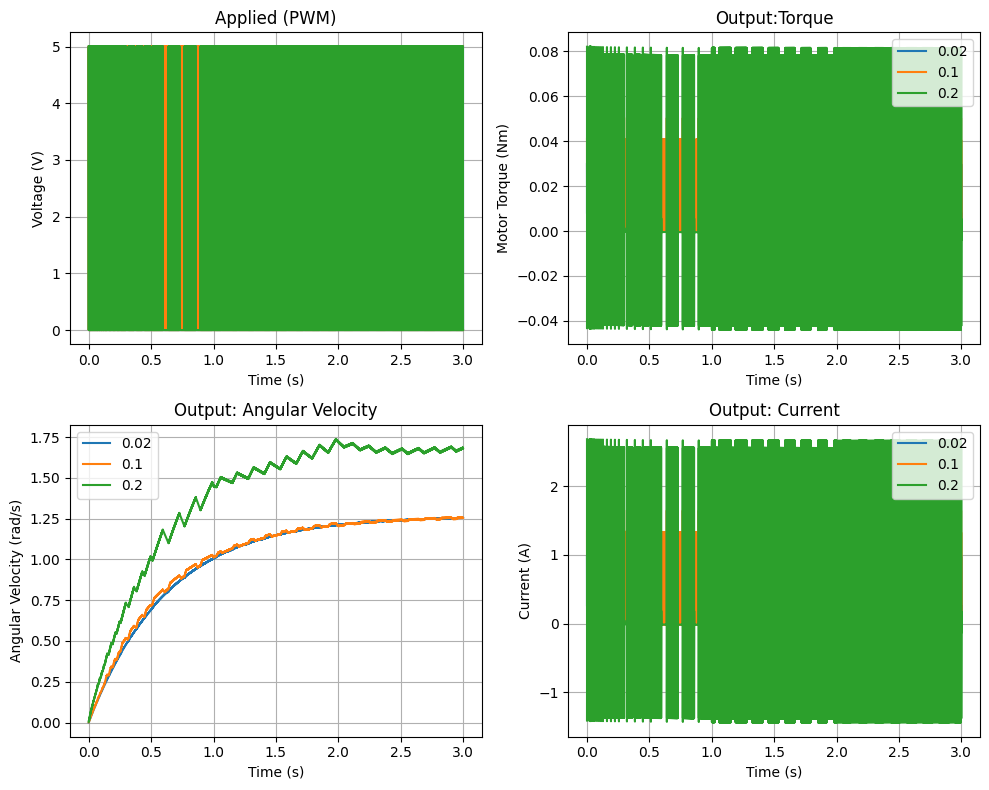

In [14]:
T=1e-3
TH=T*0.1
dt = 1e-3*np.array([0.02,0.1, 0.2])
t_end = 3000e-3  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for dtx in dt:
    simulationTest_motordc_timeSeries(dtx, t_end,T,TH,dtx*1000,'pwm')
plt.tight_layout()
plt.legend()
plt.show()


### Simulation  - transfer curve - DAC vs PWM sweep
(not terminated, work in progress)

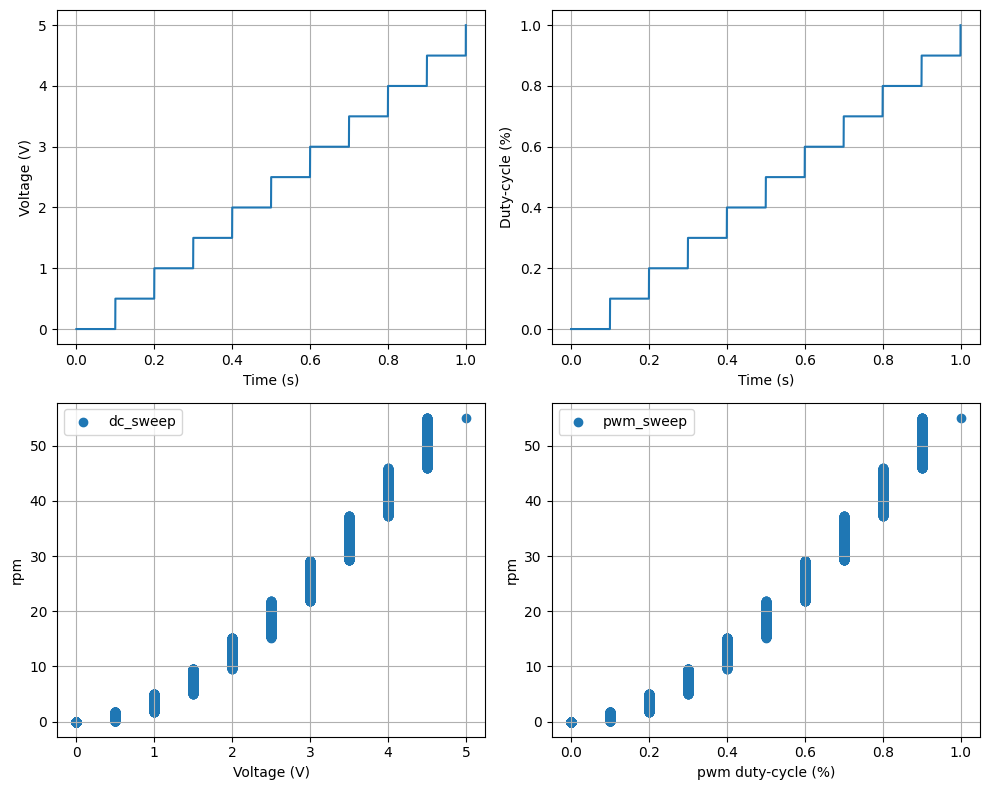

In [15]:
# Transfer curve function for DC motor simulator 
import numpy as np
import math
import matplotlib.pyplot as plt

def simulationTest_motordc_transferCurve(dt, t_end,T,dT,dTmeasure):

    t = np.arange(0, t_end + dt, dt)

    # Number of steps
    n_steps = int((t_end + dt) // dT)
    step_values = np.linspace(0, 1, n_steps + 1)

    # Create stairway function
    stairway = np.zeros_like(t)
    for i in range(n_steps + 1):
        stair_start = int(i * dT / dt)
        stair_end = int((i + 1) * dT / dt)
        stairway[stair_start:stair_end] = step_values[i]

    # DC sweep

    # initialize start values
    qr = 0.0
    qr_d = 0.0
    curr = 0.0
    curr_prev = 0.0
    curr_d = 0.0
    #initialize output
    wmm = []
    Vmm = []

    V=stairway*5

    for i in range(len(t)):

        #value = MotorDynamics(vx, dt)
        vx = V[i]  #pwm
        curr_d = (vx - qr_d * ke - R * curr) / L
        curr = curr + curr_d * dt
        value = curr * kt
        qr_dd = (value - B * qr_d) / J
        qr_d = qr_d + qr_dd * dt
        qr = qr + qr_d * dt
        curr_prev = curr
        #if t(i) % T < T*duty(i), 5, 0)
        wmm.append(qr_d)
        Vmm.append(vx)

    wmm = np.array(wmm)
    Vmm = np.array(Vmm)

    # Top-left: Time series input (voltage)
    axs[0, 0].plot(t, Vmm,label='dc_sweep-time series')
    #  axs[0, 0].set_title('Applied (PWM)')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('Voltage (V)')
    axs[0, 0].grid(True)

    # Bottom-left: Transfer curve (angular velocity)
    axs[1, 0].scatter(Vmm, wmm*60/6.28, label='dc_sweep')
    #   axs[1, 0].set_title('Transfer curve: \omega VS Va')
    axs[1, 0].set_ylabel('rpm')
    axs[1, 0].set_xlabel('Voltage (V)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # PWM sweep

    # initialize start values
    qr = 0.0
    qr_d = 0.0
    curr = 0.0
    curr_prev = 0.0
    curr_d = 0.0
    #initialize output
    wmm2 = []
    Vmm2 = []

    duty=stairway

    for i in range(len(t)):

        #value = MotorDynamics(vx, dt)
        vx = np.where((t[i] % T) < T*duty[i], 5, 0)  #pwm
        curr_d = (vx - qr_d * ke - R * curr) / L
        curr = curr + curr_d * dt
        value = curr * kt
        qr_dd = (value - B * qr_d) / J
        qr_d = qr_d + qr_dd * dt
        qr = qr + qr_d * dt
        curr_prev = curr
        #if t(i) % T < T*duty(i), 5, 0)
        wmm2.append(qr_d)
        Vmm2.append(vx)

    wmm2 = np.array(wmm)
    Vmm2 = np.array(Vmm)

    # Top-right: Time series input (voltage)
    axs[0, 1].plot(t, duty,label='pwm_sweep-time series')
 #   axs[0, 1].set_title('Applied (PWM)')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Duty-cycle (%)')
    axs[0, 1].grid(True)

    # Bottom-right: Transfer curve (angular velocity)
    axs[1, 1].scatter(duty, wmm2*60/6.28, label='pwm_sweep')
  #  axs[1, 1].set_title('Transfer curve: \omega VS Va')
    axs[1, 1].set_ylabel('rpm')
    axs[1, 1].set_xlabel('pwm duty-cycle (%)')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

T=1e-3
dT=100*T
dTmeasure=dT;
dt = 0.1e-3
t_end = 1000e-3  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
simulationTest_motordc_transferCurve(dtx, t_end,T,dT,dTmeasure)
plt.tight_layout()
plt.legend()
plt.show()


### Simulation  - DC motor - torque/speed curves
(not terminated, work in progress)

In [16]:
resetInitialState()


### DC motor with wheel simulation

### Pendulum simulation

In [17]:
def Forwardkinematics(q):
    x = L2 * math.sin(q)
    y = L2 * math.cos(q)
    return x, y

def PendulumEnergy(q):
    K = (
        (0.5 * m1 * math.pow(qp_d * L1, 2))
        + (0.5 * m2 * math.pow(qp_d * L2, 2))
        + (0.5 * J * qp_d * qp_d)
        + (0.5 * I1 * qp_d * qp_d)
    )  # Kinetic energy
    P = (m1 + m2) * g * L2 * math.cos(q)  # Potential energy
    return K + P



### Sensor simulation



### Controller simulation


In [18]:
# LQR parameter
a = (m1 * L1 * L1) + (m2 * L2 * L2) + (I1)
b = (m1 * L1 + m2 * L2) * g

a21 = b/a
a24 = (kt * ke * Ng * Ng)/(a * R)
a41 = -b/a
a44 = -(a + J) * (kt * ke * Ng * Ng) /(a * J * R)

b2 = -(kt*Ng)/(a*R)
b4 = (a + J) * (kt * Ng)/(a * J * R)

A_matrix = np.array([[0, 1, 0, 0],
                     [a21, 0, 0, a24],
                     [0, 0, 0, 1],
                     [a41, 0, 0 , a44]])

B_Matrix = np.array([[0],
                     [b2],
                     [0],
                     [b4]])

desired_poles = []



### System simulation

In [19]:
def RwipDynamics(q, Tr, Tp):
    qdd = (
        (m1 * g * L1 * math.sin(q)) + (m2 * g * L2 * math.sin(q)) - Tr + Tp - dp * qp_d
    ) / ((m1 * L1**2.0) + (m2 * L2) + I1)
    return qdd


### Set up the simulator

In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt


In [21]:
import pygame
from pygame.locals import QUIT, MOUSEBUTTONDOWN, KEYDOWN
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import pygetwindow as gw
import pyaudio
import threading
import control
#import source.content.project3.code.thai.param as param  #only required when using param.py file


pygame 2.6.1 (SDL 2.28.4, Python 3.13.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Visualization

In [22]:
def plot_figure(screen, qp, qp_d, qr_d, Tm, Vin, Tp, setpoint):
    x_offset = 200
    y_offset = 360
    multiplier = 800

    # Draw RWIP
    x, y = Forwardkinematics(qp)
    x, y = x_offset - x * multiplier, y_offset - y * multiplier
    pygame.draw.line(screen, BLACK, (x_offset, y_offset), (x, y), 5)

    # Draw wheel
    pygame.draw.circle(screen, GREY, (x, y), wheelradius * multiplier, 8)

    # Draw cross
    cross_length = wheelradius * multiplier
    cross_dx = cross_length * np.sin(qr) * 0.8
    cross_dy = -cross_length * np.cos(qr) * 0.8
    pygame.draw.line(
        screen, BLACK, (x - cross_dx, y - cross_dy), (x + cross_dx, y + cross_dy), 2
    )
    pygame.draw.line(
        screen, BLACK, (x - cross_dy, y + cross_dx), (x + cross_dy, y - cross_dx), 2
    )

    # Draw pendulum point
    pygame.draw.circle(screen, BLACK, (x, y), 5)
    pygame.draw.circle(screen, BLACK, (x_offset, y_offset), 5)

    # Draw text
    font = pygame.font.Font(None, 18)
    texts = [
        f"Setpoint (deg): {round(np.rad2deg(setpoint), 2)}",
        f"Pendulum Angle (deg): {round(np.rad2deg(qp), 2)}",
        f"Pendulum Speed (deg/s) : {round(np.rad2deg(qp_d), 2)}",
        f"Controller Mode : {controller_mode}",
    ]
    for i, text in enumerate(texts):
        rendered_text = font.render(text, True, WHITE)
        screen.blit(rendered_text, (10, 80 + i * 20))
    
    texts = [
        f"Motorspeed (RPM): {round(qr_d * 60 / (math.pi * 2), 2)}",
        f"Apply Torque (Nm): {round(Tm, 2)}",
        f"Vin (V): {round(Vin, 2)}",
    ]
    for i, text in enumerate(texts):
        rendered_text = font.render(text, True, WHITE)
        screen.blit(rendered_text, (230, 80 + i * 20))

    texts = [
        f"FUEL: {round(controller_energy, 2)}",
        f"TIME: {round(controller_time, 2)}",
    ]
    for i, text in enumerate(texts):
        rendered_text = font.render(text, True, BLACK)
        screen.blit(rendered_text, (10, 170 + i * 20))


def plot_graph():
    plt.clf()

    # Create the first subplot
    plt.subplot(2, 1, 1)
    plt.plot(timedt_data, qp_data, label="qp", color="blue", linewidth=2)
    plt.plot(timedt_data, setpoint_data, label="setpoint", color="red", linewidth=2)
    plt.legend()

    # Create the second subplot
    plt.subplot(2, 1, 2)
    plt.plot(timedt_data, qr_d_data, label="qr_d", color="purple", linewidth=2)
    plt.legend(loc="upper left")
    ax2 = plt.twinx()
    ax2.plot(timedt_data, Tm_data, label="Tm", color="green", linewidth=2)
    ax2.set_ylim(-1, 1)
    ax2.legend(loc="upper right")

    # Display the figure
    canvas = FigureCanvas(fig)
    win.setCentralWidget(canvas)
    win.show()

def on_click(event):
    plot_graph()


### Sound (optional)

In [23]:
p = pyaudio.PyAudio()
BITRATE = 90000  # number of frames per second/frameset.
FREQUENCY = 2000  # Hz, waves per second, 261.63=C4-note.
BITRATE = max(BITRATE, FREQUENCY + 100)
stream = p.open(format=p.get_format_from_width(1), channels=1, rate=BITRATE, output=True)
stop_thread = False

def generate_sound():
    """Generate and play sound with current frequency in a loop."""
    while not stop_thread:
        # Generate wave data for 1 second
        NUMBEROFFRAMES = int(BITRATE * 0.0002)  # 1 second of sound
        WAVEDATA = ""
        for x in range(NUMBEROFFRAMES):
            try:
                WAVEDATA += chr(int(math.sin(x / ((BITRATE / FREQUENCY) / math.pi)) * 127 + 128))
            except ZeroDivisionError:
                WAVEDATA += chr(128)
        # Play sound
        stream.write(WAVEDATA)

# Start sound generation in a separate thread
sound_thread = threading.Thread(target=generate_sound)
#if param.Sound:
if Sound:
    sound_thread.start()


### Run the simulator

UnboundLocalError: cannot access local variable 'qr_d' where it is not associated with a value

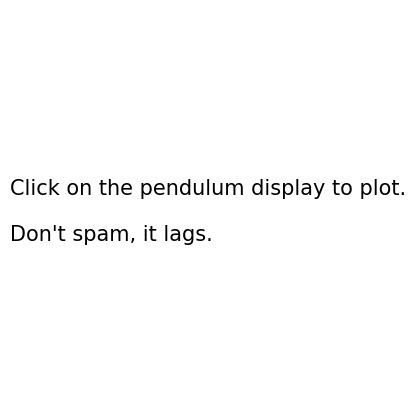

: 

In [ ]:

# ==========================================================================================
# ======================================= MAIN LOGIC =======================================
# ==========================================================================================
qp = np.deg2rad(init_qp)
qp_d = init_qp_d

qr = init_qr  # Initial reaction wheel angle
qr_d = init_qr_d  # Initial reaction wheel speed

curr_prev = 0
curr_d = 0

Tm = init_Tm  # Initial reaction wheel torque
Tp = init_Tp  # Initial disturbance torque

controller_stat_flag = False
controller_stat_flag_last = False
controller_time = 0
controller_energy = 0

timedt = 0
dt = 1 / 100  # frequency (Hz)

reqE = (m1 + m2) * g * L2 * math.cos(0)

setpoint = 0 # do not adjust

# For LQR control
K, S, E = control.lqr(A_matrix, B_Matrix, Q_LQR, R_LQR, N_LQR)

# For PID control
s = control.TransferFunction.s
G = (s/(-J-m1*L1*L1))/((s**3 + ((B/I1) + (B + dp)/(m2*L2*L2))*s**2 - ((m1*L1 + m2*L2)*g/((J + m2*L2*L2)*I1) - (B + dp)/((J+m2*L2*L2)*I1))*s - (m1*L1 + m2*L2)*B*g/((J+m2*L2*L2)*I1)))
C = 1/s

# Plot the root locus
if Stabilize_Controller == "PID" and plot_rootlocus:
    print("PID Mode")
    print("Waiting for root locus ...")
    print(G)
    control.rlocus(C*G)
    print("Systemzero: ", control.zero(G))
    print("Systempoles: ", control.pole(G))
    plt.title('Root Locus Plot')
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.grid(True)
    plt.show()
    print("Initialize simulation")


d_flag = 0

settled_flag = False
wait_flag = False

running = True
input_flag = False
input_string = ""

pygame.init()

width, height = 400, 560
screen = pygame.display.set_mode((width, height))
pygame.display.set_caption("Reaction Wheel Inverted Pendulum")
pygame_windows = gw.getWindowsWithTitle("Reaction Wheel Inverted Pendulum")

WHITE = (255, 255, 255)
GREY = (100, 100, 100)
RED = (255, 0, 0)
BLACK = (0, 0, 0)

font = pygame.font.Font(None, 36)
clock = pygame.time.Clock()

app = QApplication(sys.argv)
win = QMainWindow()
win.setWindowFlag(Qt.FramelessWindowHint)  # Remove the title bar
fig = plt.figure(num="plot output", figsize=(5, 5))
plt.text(0, 0.4, "Click on the pendulum display to plot.\n\nDon't spam, it lags.", fontsize = 15)
plt.axis('off')
canvas = FigureCanvas(fig)
win.setCentralWidget(canvas)
win.show()
plt.gcf().canvas.mpl_connect('button_press_event', on_click)

#variable initialization
timedt_data = []
qp_data = []
setpoint_data = []
Tm_data = []
qr_d_data = []

while running:
    for event in pygame.event.get():
        if event.type == QUIT:  #close event
            running = False
        elif event.type == MOUSEBUTTONDOWN: #reset event
            if 10 < event.pos[0] < 110 and 10 < event.pos[1] < 60:
                input_flag = True
            if 292 < event.pos[0] < 392 and 10 < event.pos[1] < 60:
                qp = np.deg2rad(init_qp)
                qp_d = init_qp_d 
                qr = init_qr
                qr_d = init_qr_d
                Tm = 0
                Tp = 0
                settled_flag = False
                wait_flag = False
                timedt = 0 
                timedt_data = []
                qp_data = []
                setpoint_data = []
                Tm_data = []
                qr_d_data = []
                controller_time = 0
                controller_energy = 0
            if event.pos[1] > 160:
                plot_graph()
        elif event.type == KEYDOWN:  #not sure what event
            if event.key == pygame.K_BACKSPACE:
                input_string = input_string[:-1]
            elif event.key == pygame.K_RETURN:
                input_flag = True
            else:
                input_string += event.unicode

    if input_flag == True:  #event: inject external perturbation torque Tp 
        try:
            Tp = -float(input_string)
        except:
            Tp = 0
            input_string = ""
        input_flag = False
    else:
        Tp = 0

    # ==========================================================================================
    # ======================================= Controller =======================================
    # ==========================================================================================
    setpoint_offset = (qp - math.pi) / (2 * math.pi) #why ?
    if setpoint_offset < 0:
        setpoint = (math.floor(setpoint_offset) + 1) * 2 * math.pi
    elif setpoint_offset > 0:
        setpoint = math.ceil(setpoint_offset) * 2 * math.pi
    #well: would be more convenient to fold the phase

    E = PendulumEnergy(q=qp)

    if wait_flag:
        controller_mode = "brake"
        if abs(E) < 0.05:   #should be a parameter
            wait_flag = False
    elif abs(qp) % (2 * math.pi) <= np.deg2rad(StabilizeBound) or abs(qp) % (2 * math.pi) >= np.deg2rad(360 - StabilizeBound):
        settled_flag = True
        controller_mode = Stabilize_Controller
        controller_stat_flag = True
    else:
        if settled_flag:
            wait_flag = True
            settled_flag = False
        if not wait_flag:
            controller_mode = "Bang-bang"

    if controller_mode == "LQR":
        e = setpoint - qp
        Vin = e * K[0, 0] + qp_d * -K[0, 1]
    elif controller_mode == "PID":
        e = setpoint - qp
        Vin = -e * Kp
    elif controller_mode == "Bang-bang":
        if (qp_d < 0 and E < reqE) or (qp_d >= 0 and E >= reqE):
            Vin = 12
        elif (qp_d >= 0 and E < reqE) or (qp_d < 0 and E >= reqE):
            Vin = -12
        else:
            Vin = 0
    elif controller_mode == "brake":
        if qp_d < 0:
            Vin = -12
        elif qp_d >= 0:
            Vin = 12
    else:
        Vin = 0
    if MotorLimit:
        # Actual Limit
        if Vin > 24:
            Vin = 24
        elif Vin < -24:
            Vin = -24
            
    Tm = MotorDynamics(Vin, dt)
    FREQUENCY = pow(abs(qr_d), 2)
    qp_dd = RwipDynamics(qp, Tm, Tp)
    qp_d = qp_d + (qp_dd * dt)
    qp = qp + (qp_d * dt)

    # Draw background
    screen.fill(WHITE)
    pygame.draw.rect(screen, (24, 24, 24), (0, 0, 401, 160))

    # Draw grid
    for i in range(0, 401, 50):
        pygame.draw.line(screen, GREY, (i, 160), (i, 600), 1)
    for i in range(160, 560, 50):
        pygame.draw.line(screen, GREY, (0, i), (400, i), 1)

    # Draw figure
    plot_figure(screen, qp, qp_d, qr_d, Tm, Vin, Tp, setpoint)
    timedt_data.append(timedt)
    qp_data.append(qp)
    setpoint_data.append(setpoint)
    Tm_data.append(Tm)
    qr_d_data.append(qr_d)

    # move graph with pygame
    win.move(pygame_windows[0].left + 420, pygame_windows[0].top + 50)
    win.showNormal()

    # Draw button
    pygame.draw.rect(screen, GREY, (10, 10, 100, 50))
    text = font.render("INJECT", True, WHITE)
    screen.blit(text, (20, 23))
    pygame.draw.rect(screen, RED, (292, 10, 100, 50))
    text = font.render("RESET", True, (255, 255, 255))
    screen.blit(text, (303, 23))

    # Draw disturbance input field
    pygame.draw.rect(screen, GREY, (110, 10, 130, 50))
    pygame.draw.rect(screen, WHITE, (125, 20, 100, 30))
    text = font.render(input_string, True, (0, 0, 0))
    screen.blit(text, (130, 25))

    # calculate FPS and draw
    fps = clock.get_fps()
    timedt += dt
    if(abs(np.rad2deg(qp) - np.rad2deg(setpoint)) < 0.1):
        controller_stat_flag = False
    elif(controller_stat_flag):
        controller_time += dt
        controller_energy += abs(qr_d * Tm) * dt
    if(controller_mode != Stabilize_Controller or not controller_stat_flag_last and controller_stat_flag and (abs(np.rad2deg(qp) - np.rad2deg(setpoint)) < 0.1)):
        controller_time = 0
        controller_energy = 0
    controller_stat_flag_last = controller_stat_flag
    if fps:
        dt = 1 / fps

    pygame.display.flip()
    clock.tick(165)

pygame.quit()
stop_thread = True
sys.exit()


### Usage

![Image of the program](https://github.com/B-Paweekorn/Reaction-wheel-inverted-pendulum/assets/47713359/e2ff45d4-bfb2-4831-9ec9-334b88f8ff77)

**Inject** - Type the amount of torque into the box and click `INJECT` or ENTER key to inject a disturbance to the system

**Reset** - Click `RESET` to reset the system

**Plotting** - Click on the pendulum plot or the plot window to plot the data

Edit the parameters in ```param.py``` (or above)S


### Example runs

### Export to python script?